# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

### Set de datos

### MLP

### CNN Redes Convolucionales

2023-05-18 15:09:51.609630: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
1875/1875 [==============================] - 43s 22ms/step - loss: 0.1685 - accuracy: 0.9500 - val_loss: 0.0657 - val_accuracy: 0.9779
Epoch 2/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0579 - accuracy: 0.9824 - val_loss: 0.0542 - val_accuracy: 0.9823
Epoch 3/10
1875/1875 [==============================] - 50s 26ms/step - loss: 0.0383 - accuracy: 0.9880 - val_loss: 0.0524 - val_accuracy: 0.9827
Epoch 4/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.0511 - val_accuracy: 0.9835
Epoch 5/10
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0498 - val_accuracy: 0.9854
Epoch 6/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0440 - val_accuracy: 0.9865
Epoch 7/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.0506 -

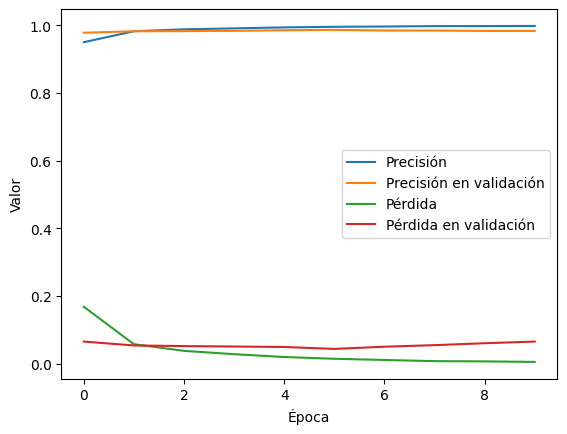

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Cargar el conjunto de datos MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalizar los datos de entrada (escalado entre 0 y 1)
train_images = train_images / 255.0
test_images = test_images / 255.0

# Agregar una dimensión adicional para el canal de color (escala de grises)
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Crear el modelo de la red convolucional
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Precisión en el conjunto de prueba:", test_acc)

# Graficar la precisión y la pérdida durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.plot(history.history['loss'], label='Pérdida')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [5]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Cargar el conjunto de datos MNIST
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Filtrar las imágenes con el filtro bilateral (solo se ejecuta una vez)
filtered_train_images = np.zeros_like(train_images)
filtered_test_images = np.zeros_like(test_images)

for i in range(len(train_images)):
    filtered_train_images[i] = cv2.bilateralFilter(train_images[i], 9, 75, 75)

for i in range(len(test_images)):
    filtered_test_images[i] = cv2.bilateralFilter(test_images[i], 9, 75, 75)

# Normalizar los datos de entrada (escalado entre 0 y 1)
train_images = train_images / 255.0
test_images = test_images / 255.0
filtered_train_images = filtered_train_images / 255.0
filtered_test_images = filtered_test_images / 255.0

# Agregar una dimensión adicional para el canal de color
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
filtered_train_images = filtered_train_images.reshape(-1, 28, 28, 1)
filtered_test_images = filtered_test_images.reshape(-1, 28, 28, 1)

# Crear la CNN sin procesar
model_raw = models.Sequential()
model_raw.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_raw.add(layers.MaxPooling2D((2, 2)))
model_raw.add(layers.Flatten())
model_raw.add(layers.Dense(64, activation='relu'))
model_raw.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN sin procesar
model_raw.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_raw.fit(train_images, train_labels, epochs=10)

# Evaluar la CNN sin procesar en el conjunto de prueba
_, test_acc_raw = model_raw.evaluate(test_images, test_labels)

# Crear la CNN con imágenes filtradas
model_filtered = models.Sequential()
model_filtered.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_filtered.add(layers.MaxPooling2D((2, 2)))
model_filtered.add(layers.Flatten())
model_filtered.add(layers.Dense(64, activation='relu'))
model_filtered.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes filtradas
model_filtered.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

model_filtered.fit(filtered_train_images, train_labels, epochs=10)

# Evaluar la CNN con imágenes filtradas en el conjunto de prueba
_, test_acc_filtered = model_filtered.evaluate(filtered_test_images, test_labels)

# Imprimir los resultados
print("Precisión en el conjunto de prueba sin procesar:", test_acc_raw)
print("Precisión en el conjunto de prueba con filtro bilateral:", test_acc_filtered)


Epoch 1/10
1875/1875 [==============================] - 62s 32ms/step - loss: 0.1637 - accuracy: 0.9514
Epoch 2/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0578 - accuracy: 0.9825
Epoch 3/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0405 - accuracy: 0.9877
Epoch 4/10
1875/1875 [==============================] - 78s 41ms/step - loss: 0.0289 - accuracy: 0.9912
Epoch 5/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0224 - accuracy: 0.9929
Epoch 6/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0160 - accuracy: 0.9947
Epoch 7/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0116 - accuracy: 0.9962
Epoch 8/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0088 - accuracy: 0.9972
Epoch 9/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0079 - accuracy: 0.9975
Epoch 10/10
313/313 [==============================] - 5s 12ms/s